### Presenters: Khan Sana Munir, Hafiz Shakeel Ahmad, Ahmed Maaz
***

# <span style="color:#320054">Chapter 9 (Recap/Summary) - Using PyTorch to fight cancer</span>
***
1. 5 steps in our cancerous nodule detection approach: data loading, segmentation, grouping, classification, and nodule analysis & diagnosis.
2. Breaking down the project into smaller subprojects makes teaching easier.
3.  Focusing the model on relevant CT scan crop will make training easier.
4.  Understanding CT scan data is important for accurate processing routines.
5.  Key concept in the project is nodules, small masses in the lungs visible on CT scans.
6.  LUNA Grand Challenge data used for training, includes CT scans and human-annotated outputs. High-quality data is important for project success.

</br>


# <span style="color:#320054">Chapter 10 (Recap) - Using PyTorch to fight cancer</span>
***
1. Ct class loads data and provides access to cropped regions. <br>
2. Caching can be done in memory or on disk if parsing/loading is expensive.
3. PyTorch Dataset subclasses convert data into tensors for the model.
4. Subclasses of Dataset require implementations for len and getitem.
5. Splitting data into training and validation sets requires consistent sort order.
6. Data visualization important; using Jupyter Notebooks and Matplotlib for rendering.

</br>


# <span style="color:#320054">Chapter 11 -Training a classification model to detect suspected tumors</span>
***
1. Using PyTorch DataLoaders to load data
2. Implementing a model that performs classification on our CT data
3. Setting up the basic skeleton for our application
4. Logging and displaying metrics

</br>

## <span style="color:#004654">11.1 A foundational model and training loop</span>
***

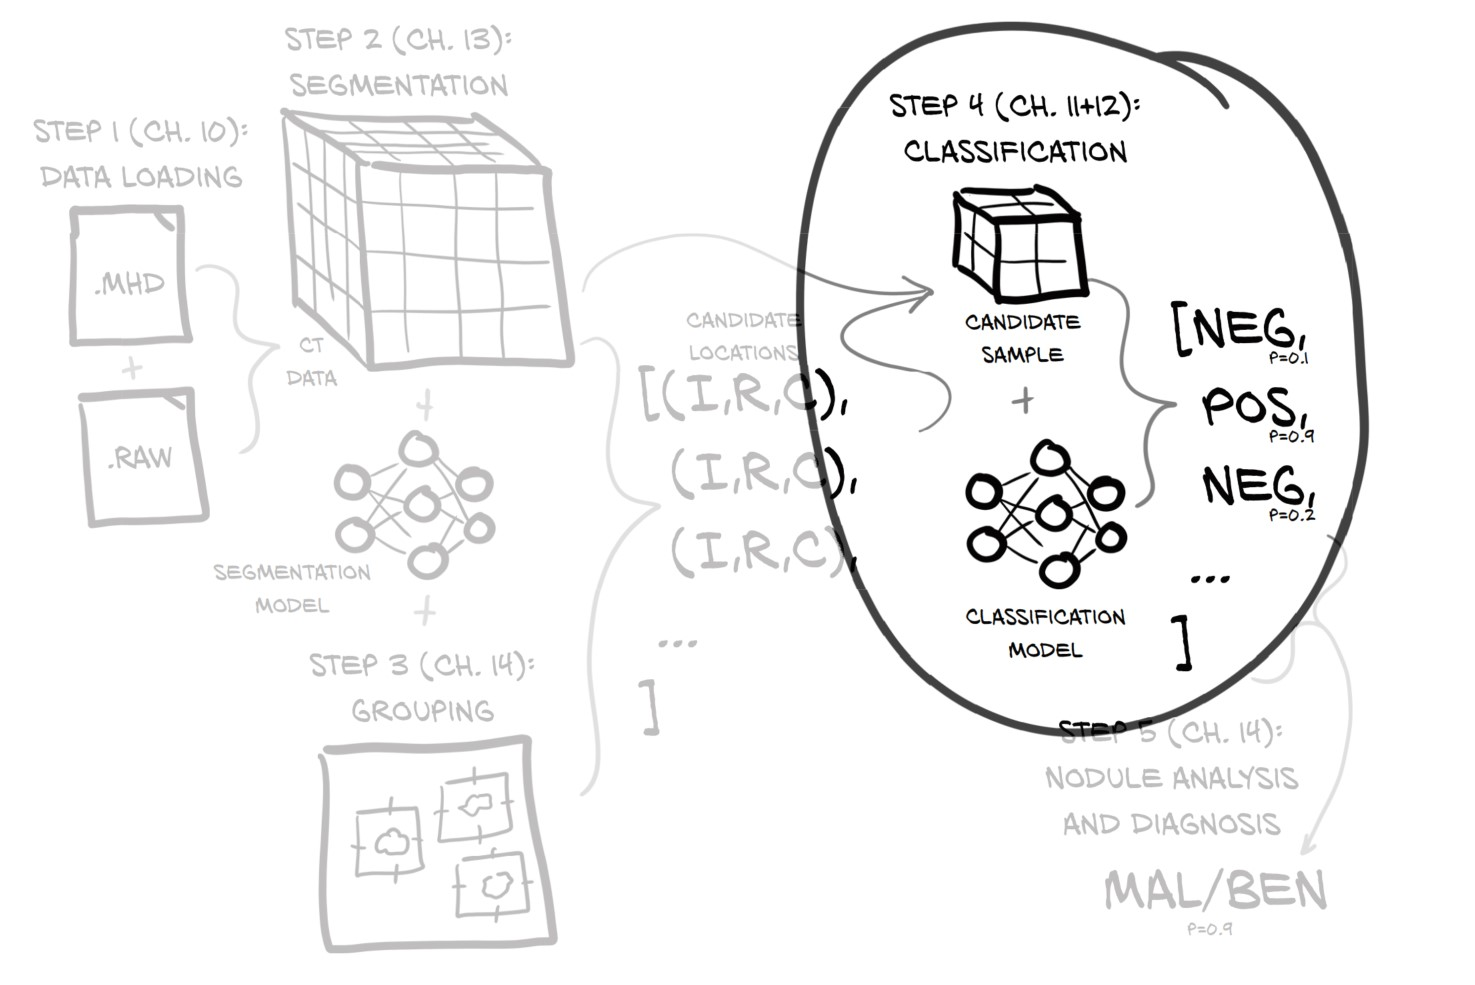

In [1]:
from IPython import display

display.Image("data/images/11.1.jpg")

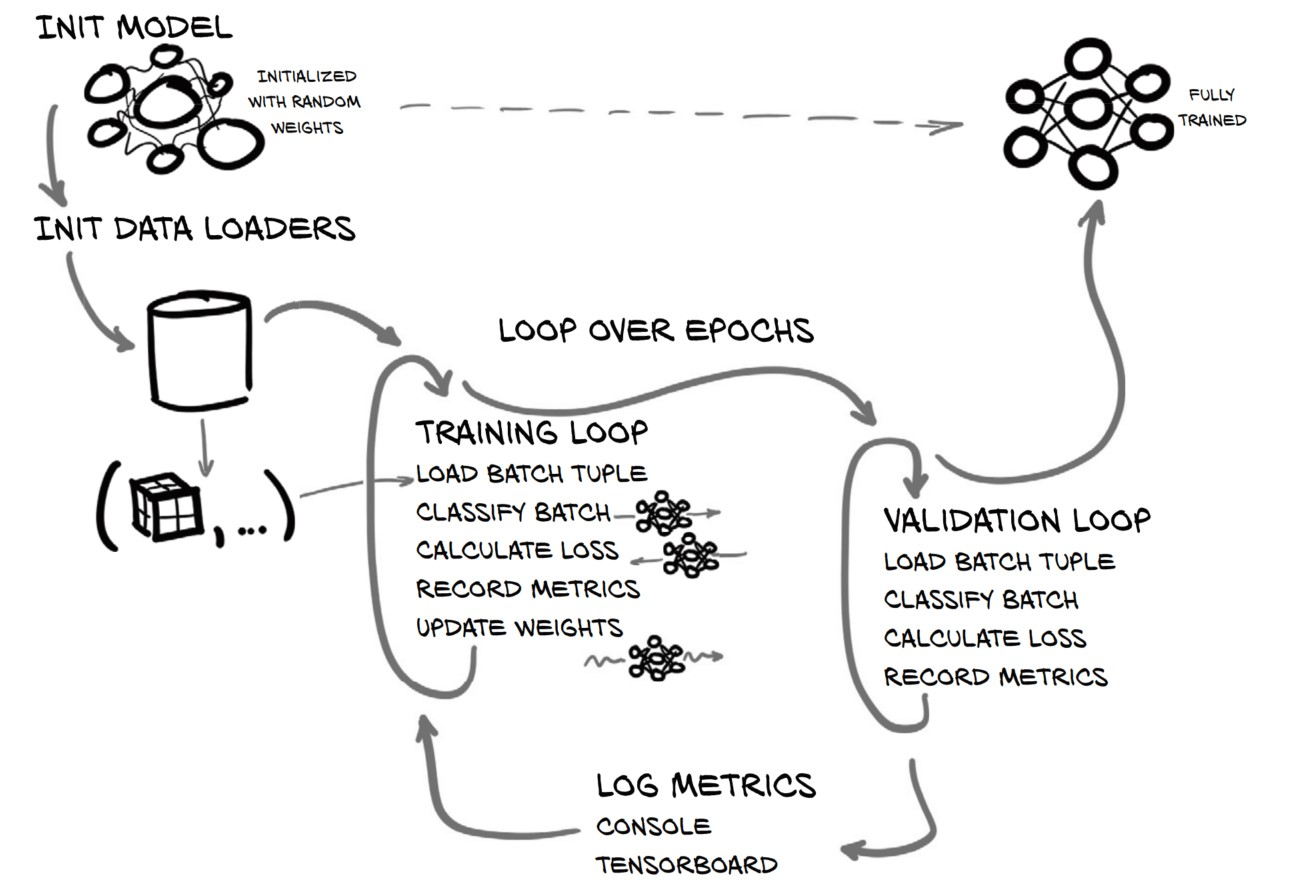

In [2]:
from IPython import display

display.Image("data/images/11.2.jpg")

### The basic structure of what we’re going to implement is as follows:
 1. Initialize our model and data loading.<br>
 2. Loop over a semi-arbitrarily chosen number of epochs. 
     + **Loop over each batch of training data** returned by LunaDataset. 
     + The data-loader worker process **loads the relevant batch** of data in the background. 
     + **Pass the batch** into our classification model to get results. 
     + **Calculate our loss** based on the difference between our predicted results and our ground-truth data.
     + **Record metrics** about our model’s performance into a temporary data structure. 
     + **Update the model weights** via backpropagation of the error.
     
     + **Loop over each batch of validation data** (in a manner very similar to thetraining loop). 
     + **Load the relevant batch of validation data** (again, in the background worker process). 
     + **Classify the batch**, and **compute the loss**. 
     + **Record metrics** about how well the model performed on the validation data. 
     + **Log Metrics** -> Print out progress and performance information for this epoch. 

## <span style="color:#004654">11.2 The main entry point for our application</span>
***

Part 2 of the book involves creating a **command-line application** with features like parsing command-line arguments and a help command, making it easy to run in various environments. This will allow for easy invocation of the training routines from both Jupyter and a Bash shell.
<br><br>
The application will be built using a **class structure** to simplify instantiation and invocation, eliminating the need for a second OS-level process. This approach provides **benefits for testing, debugging, and integration** with other Python programs. <br>

In [3]:
#import libraries
import argparse
import datetime
import os
import sys
import numpy as np
import torch
import torch.nn as nn

from torch.utils.tensorboard import SummaryWriter
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader

#local imports
from util.util import enumerateWithEstimate, importstr
from dsets import LunaDataset
from util.logconf import logging
from model import LunaModel

# set logs
log = logging.getLogger(__name__)
# log.setLevel(logging.WARN)
log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

In [8]:
def run(app, *argv):
    argv = list(argv)
    argv.insert(
        0, "--num-workers=4"
    )  # We assume you have a four-core, eightthread CPU. Change the 4 if needed
    log.info("Running: {}({!r}).main()".format(app, argv))

    app_cls = importstr(
        *app.rsplit(".", 1)
    )  # This is a slightly cleaner call to __import__.
    app_cls(argv).main()

    log.info("Finished: {}.{!r}).main()".format(app, argv))


run('training.LunaTrainingApp', '--epochs=1')

2023-05-08 08:45:04,329 INFO     pid:5620 __main__:006:run Running: training.LunaTrainingApp(['--num-workers=4', '--epochs=1']).main()
2023-05-08 08:45:04,333 INFO     pid:5620 training:080:initModel Using CUDA; 1 devices.
2023-05-08 08:45:04,337 INFO     pid:5620 training:138:main Starting LunaTrainingApp, Namespace(num_workers=4, batch_size=32, epochs=1, tb_prefix='p2ch11', comment='dwlpt')
2023-05-08 08:45:04,342 INFO     pid:5620 dsets:182:__init__ <dsets.LunaDataset object at 0x000001E351D29BB0>: 12207 training samples
2023-05-08 08:45:04,343 INFO     pid:5620 dsets:182:__init__ <dsets.LunaDataset object at 0x000001E35E75BDC0>: 1357 validation samples
2023-05-08 08:45:04,344 INFO     pid:5620 training:144:main Epoch 1 of 1, 382/43 batches of size 32*1
2023-05-08 08:45:04,346 WARNING  pid:5620 util.util:219:enumerateWithEstimate E1 Training ----/382, starting
2023-05-08 08:45:11,907 INFO     pid:5620 util.util:236:enumerateWithEstimate E1 Training   16/382, done at 2023-05-08 08:45

The code starts with a common piece of code called "if main" that creates an application object and runs its main method.This code initializes a class called **"LunaTrainingApp"** and calls its **"main"** method if the script is being run as the main program.

In [ ]:
if __name__ == '__main__':
    LunaTrainingApp().main() 

Let's look at the application class "LunaTrainingApp" and the two functions (__init__ and main):
+ The **"argparse"** library is used to accept command-line arguments in the **"init"** function of the class. <br>
+ The **"main"** method is the primary entry point for the application's core logic. <br> 
+ **Custom arguments** can also be passed into the initializer if desired.

In [26]:
class LunaTrainingApp:
    def __init__(self, sys_argv=None):
        if sys_argv is None:
            sys_argv = sys.argv[1:]

        parser = argparse.ArgumentParser()
        parser.add_argument('--num-workers',
                            help='Number of worker processes for background data loading',
                            default=8,
                            type=int,
                            )
        parser.add_argument('--batch-size',
                            help='Batch size to use for training',
                            default=32,
                            type=int,
                            )
        parser.add_argument('--epochs',
                            help='Number of epochs to train for',
                            default=1,
                            type=int,
                            )
        parser.add_argument('--tb-prefix',
                            default='p2ch11',
                            help="Data prefix to use for Tensorboard run. Defaults to chapter.",
                            )
        parser.add_argument('comment',
                            help="Comment suffix for Tensorboard run.",
                            nargs='?',
                            default='dlwpt',
                            )
        
        self.cli_args = parser.parse_args(sys_argv)
        self.time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
        
        
    def main(self):
        log.info("Starting {}, {}".format(type(self).__name__, self.cli_args))
        
        
    # code to actually run the training - coming section


## <span style="color:#004654">11.3 Pretraining setup and initialization</span>
***

Before iterating over each batch in the epoch, we need to do some initialization work. This involves **two main steps**, as shown in figure 11.3. <br>First, we need to **initialize our model and optimizer**. Second, we need to **initialize our Dataset and DataLoader instances**. <br>

The LunaDataset defines a **randomized set of samples** for the training epoch, and the DataLoader loads the data from the dataset and provides it to the application for processing.

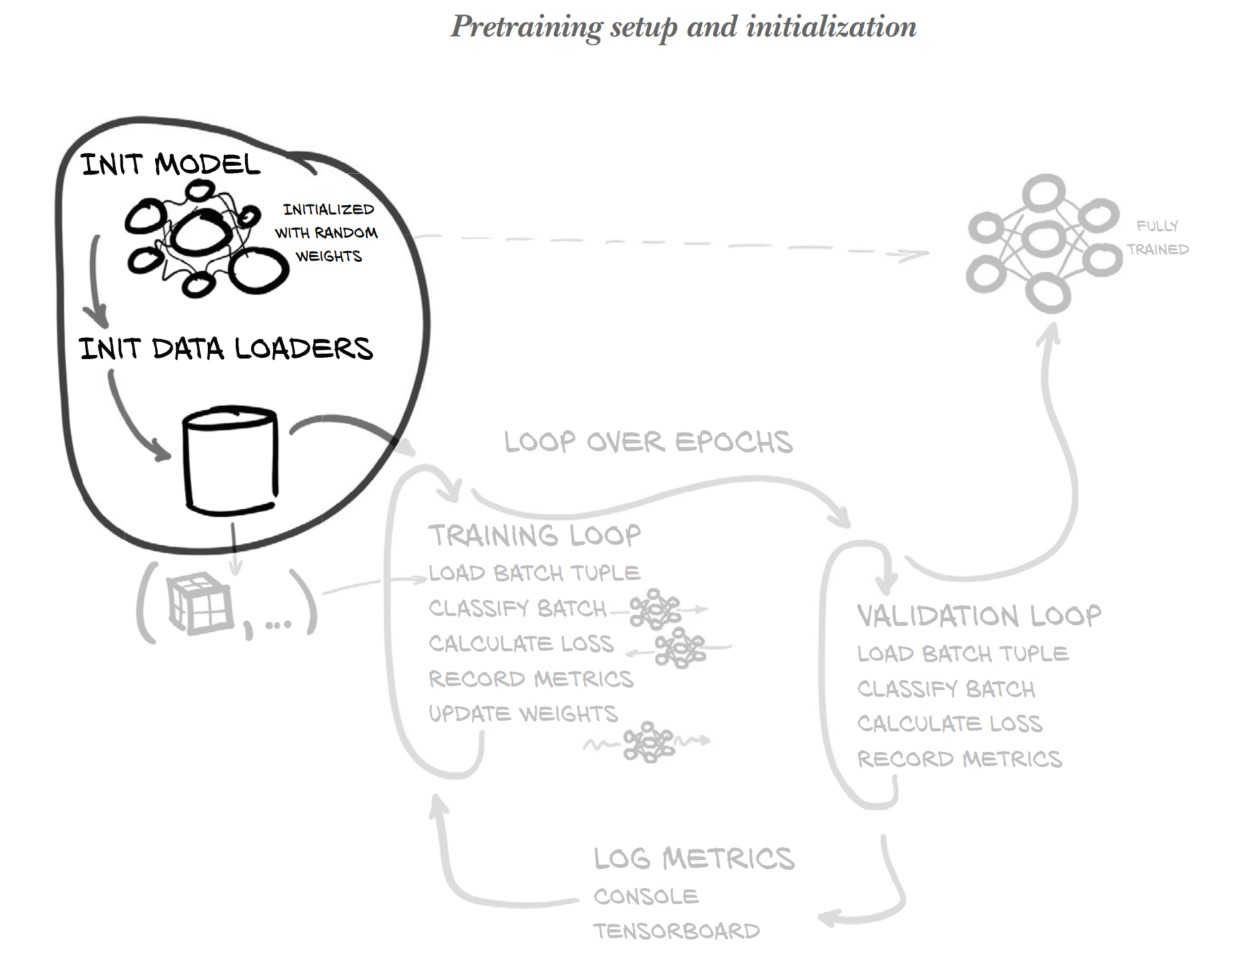

In [90]:
from IPython import display

display.Image("data/images/11.3.jpg")

## <span style="color:#004654">11.3.1 Initializing the model and optimizer</span>
***

This section treats the **implementation details of the LunaModel** as a black box, and its **internal workings** will be discussed in **section 11.4.**
<br><br>
The code **initializes the model on the GPU** before creating the optimizer; **stochastic gradient descent with momentum** is chosen as the optimizer and is considered a safe choice with a **learning rate** of **0.001** and **momentum** of **0.9**

In [27]:
class LunaTrainingApp:
    def __init__(self, sys_argv=None):
        if sys_argv is None:
            sys_argv = sys.argv[1:]

        parser = argparse.ArgumentParser()
        parser.add_argument('--num-workers',
                            help='Number of worker processes for background data loading',
                            default=8,
                            type=int,
                            )
        parser.add_argument('--batch-size',
                            help='Batch size to use for training',
                            default=32,
                            type=int,
                            )
        parser.add_argument('--epochs',
                            help='Number of epochs to train for',
                            default=1,
                            type=int,
                            )

        parser.add_argument('--tb-prefix',
                            default='p2ch11',
                            help="Data prefix to use for Tensorboard run. Defaults to chapter.",
                            )

        parser.add_argument('comment',
                            help="Comment suffix for Tensorboard run.",
                            nargs='?',
                            default='dwlpt',
                            )
        
        self.cli_args = parser.parse_args(sys_argv)
        self.time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')

        
        self.use_cuda = torch.cuda.is_available()  # Detects multiple GPUs
        self.device = torch.device("cuda" if self.use_cuda else "cpu")
        self.model = self.initModel()
        self.optimizer = self.initOptimizer()

    def initModel(self):
        model = LunaModel()
        if self.use_cuda:
            log.info("Using CUDA; {} devices.".format(torch.cuda.device_count()))
            if torch.cuda.device_count() > 1:
                model = nn.DataParallel(model)  # Wraps the model
            model = model.to(self.device)  # Sends model parameters to the GPU
        return model

    def initOptimizer(self):
        return SGD(self.model.parameters(), lr=0.001, momentum=0.99)


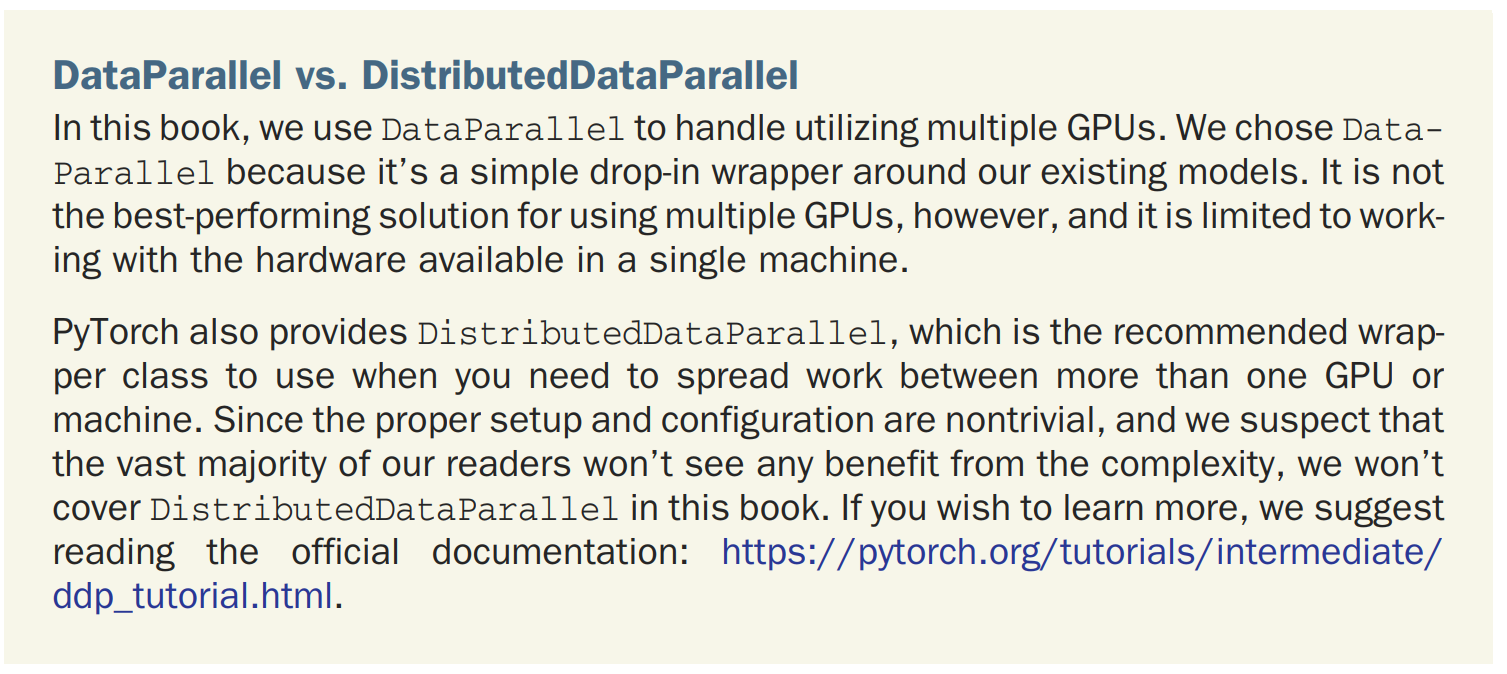

In [129]:
from IPython import display

display.Image("data/images/dataParallel.png")

## <span style="color:#004654">11.3.2 Care and feeding of data loaders</span>
***

The **LunaDataset class** acts as a bridge between unstructured data and the structured world of tensors that the PyTorch building blocks expect. For example, *torch.nn.Conv3d* expects **five-dimensional input:**(N, C, D, H, W): number of samples, channels per sample, depth, height, and width, which is quite different from the 3D data our CT provides. <br><br> Last chapter, the *ct_t.unsqueeze(0)* call in *LunaDataset.__getitem__* provides a **fourth dimension**, a "channel" for our data. **Since CT scans are single-intensity, our channel dimension is only size 1.**  <br><br>  Training on single samples at a time is typically inefficient, so grouping sample tuples together into a batch tuple is the solution. The **fifth dimension (N)** differentiates multiple samples in the same batch.

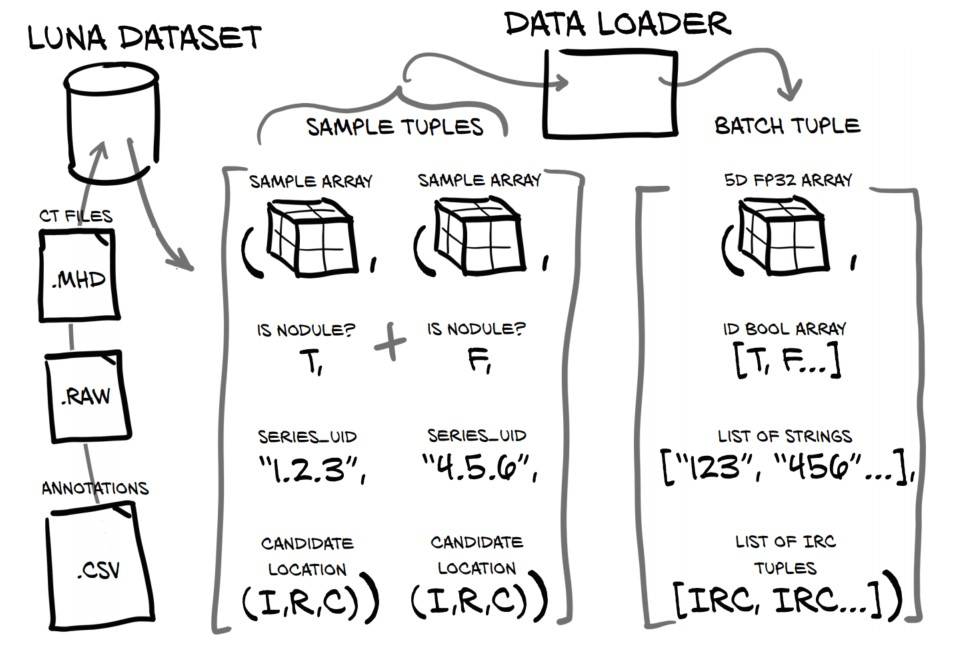

In [92]:
from IPython import display 
display.Image("data/images/11.4.jpg") 

In [28]:
def initTrainDl(self):
    train_ds = LunaDataset(
        val_stride=10,   # specifies the spacing between the slices being used for validation during the training process.
        isValSet_bool=False,
    )

    batch_size = self.cli_args.batch_size
    if self.use_cuda:
        batch_size *= torch.cuda.device_count()
        

    train_dl = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=self.cli_args.num_workers,
        pin_memory=self.use_cuda,
    )

    return train_dl


def main(self):
    train_dl = self.initTrainDl()

## <span style="color:#004654">11.4 Our first-pass neural network design</span>
***

The network design used in **chapter 8 will serve as a base for the project**, but modifications will be made to account for the **3D input data.**<br><br>
The **project's architecture** can serve as a foundation for future projects, although modifications will be necessary for projects that differ from classification or segmentation.<br><br>
The architecture of the network consists of four **repeated blocks**, and the author will begin dissecting the architecture by examining these blocks.<br><br>


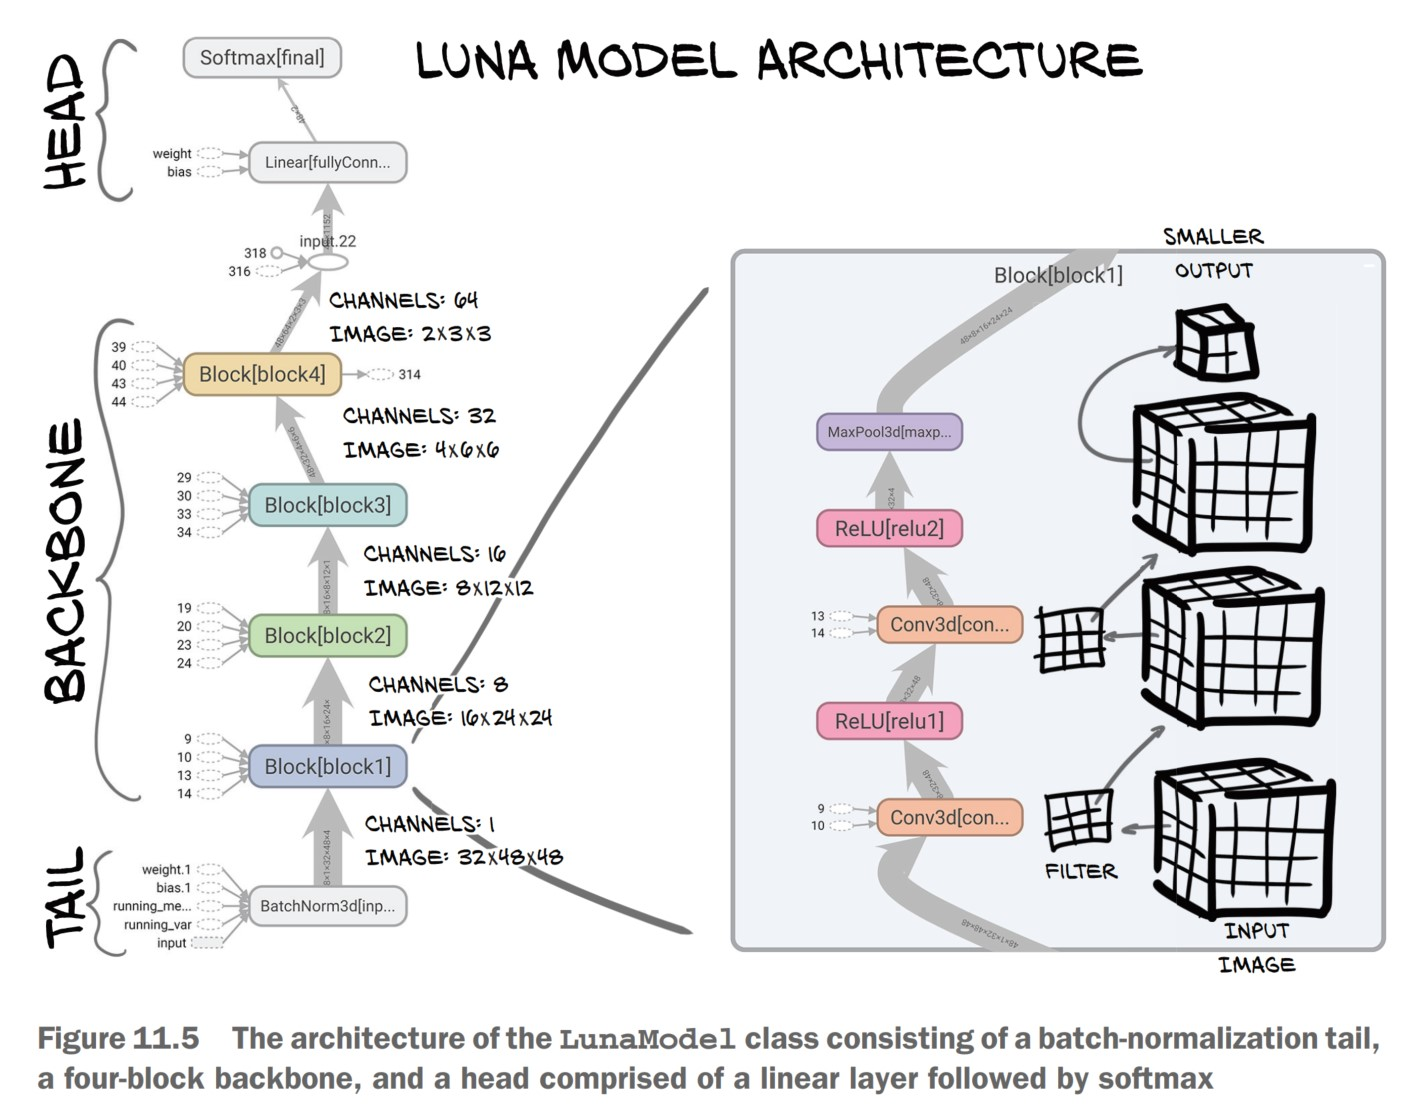

In [94]:
from IPython import display
display.Image("data/images/11.5.jpg")

## <span style="color:#004654">11.4.1 The core convolutions</span>
***

+ A classification model consists of a **tail, backbone, and head.**
+ The **tail** contains early layers that adapt the input to the expected form, and it can contain convolutional layers to aggressively downsample the image size.
+ The **backbone** contains most of the layers in a series of blocks that have the same set of layers with variations in input size and filters.
+ A typical block has two **3x3 convolutions, an activation function, and a max-pooling operation at the end.**
+ The **head** of the network converts the backbone's output into the desired output form. The process involves flattening the intermediate output and passing it to a fully connected layer.
+ The **implementation** of the block is shown in code.

In [29]:
class LunaBlock(nn.Module):
    def __init__(self, in_channels, conv_channels):
        super().__init__()

        self.conv1 = nn.Conv3d(
            in_channels, conv_channels, kernel_size=3, padding=1, bias=True,
        )
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(
            conv_channels, conv_channels, kernel_size=3, padding=1, bias=True,
        )

        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(2, 2)

    def forward(self, input_batch):
        block_out = self.conv1(input_batch)
        block_out = self.relu1(block_out)
        block_out = self.conv2(block_out)
        block_out = self.relu2(block_out)

        return self.maxpool(block_out)

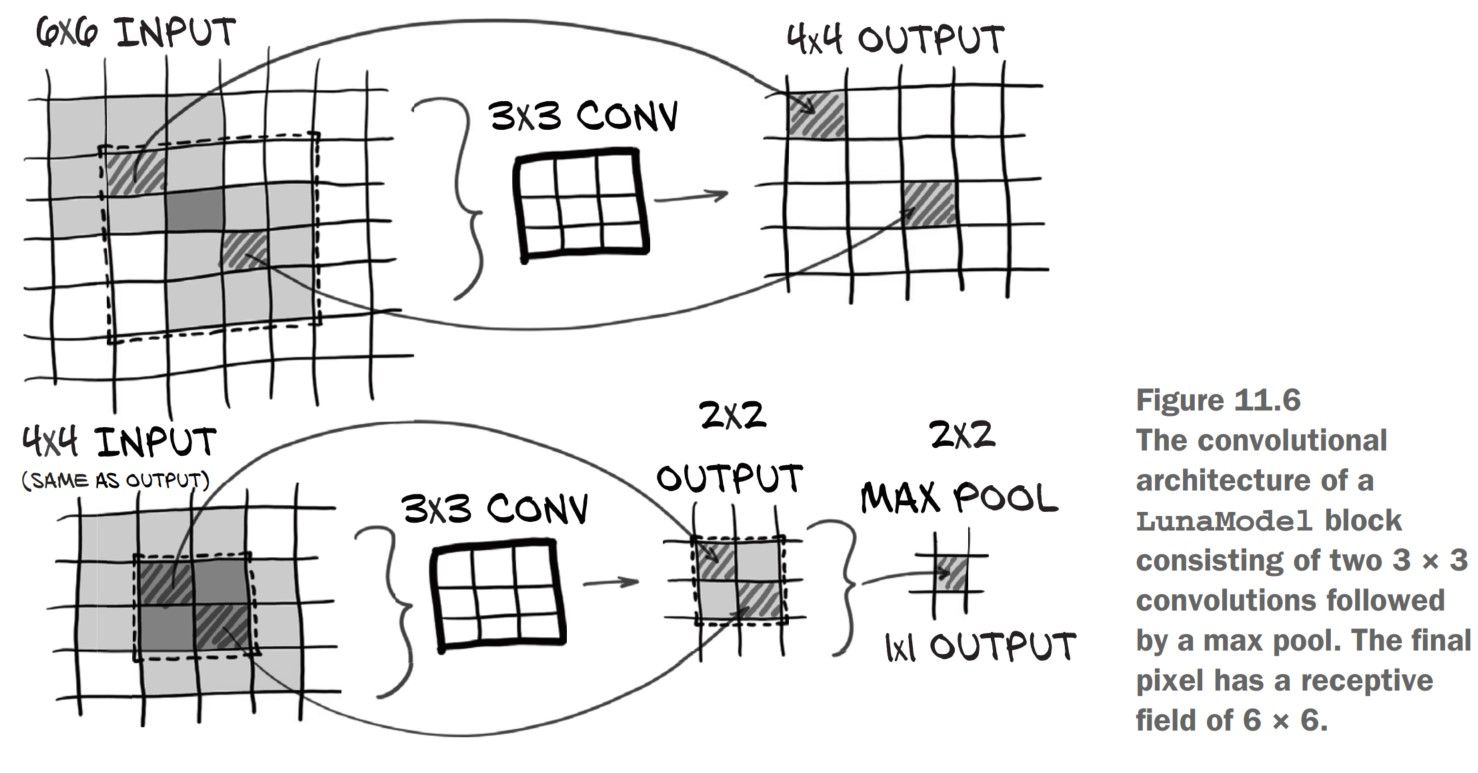

In [96]:
from IPython import display
display.Image("data/images/11.6.jpg")

The convolutions of our block represented in 2D in figure 11.6.
+ 3x3x3 convolutional layers are used in the block, with a receptive field of 3x3x3.
+ Each 3x3x3 convolutional layer adds an additional one-voxel-per-edge border to the receptive field.
+ The output of the stacked convolutions is fed into a 2x2x2 max pool, reducing the size of the output while still allowing for overlapping input fields.
+ Padded convolutions are used to keep input and output image sizes the same.
+ The nn.ReLU activation function is used, leaving outputs greater than 0.0 unchanged and clamping outputs less than 0.0 to zero.

This block will be repeated multiple times to form our model’s backbone

## <span style="color:#004654">11.4.2 The full model</span>
***

In [30]:
class LunaModel(nn.Module):
    def __init__(self, in_channels=1, conv_channels=8):
        super().__init__()

        # Tail
        self.tail_batchnorm = nn.BatchNorm3d(1)

        # Backbone
        self.block1 = LunaBlock(in_channels, conv_channels)
        self.block2 = LunaBlock(conv_channels, conv_channels * 2)
        self.block3 = LunaBlock(conv_channels * 2, conv_channels * 4)
        self.block4 = LunaBlock(conv_channels * 4, conv_channels * 8)

        # Head
        self.head_linear = nn.Linear(1152, 2)
        self.head_softmax = nn.Softmax(dim=1)

Our **tail** is relatively simple. The presented model normalizes input using **nn.BatchNorm3d** to have a mean of 0 and a standard deviation of 1. <br><br>
The **backbone** consists of four repeated blocks. Since each block ends with a 2 × 2 × 2 max-pool operation, after 4 layers we will have decreased the resolution of the image 16 times in each dimension. <br><br> The **head** includes a fully connected layer followed by *nn.Softmax*, which allows the model to express the degree of certainty in an answer. <br><br> The ***nn.Softmax*** function exponentiates every input value, divides it by the sum of all exponentiation results, and returns a bounded output between 0 and 1. Here is nonoptimized softmax implementation.

In [13]:
import math

logits = [1, -2, 3]
exp = [math.exp(x) for x in logits]
# print(math.exp(1))
print(exp)

2.718281828459045
[2.718281828459045, 0.1353352832366127, 20.085536923187668]


In [32]:
softmax = [x / sum(exp) for x in exp]
print(softmax)

[0.11849965453500957, 0.005899750401902781, 0.8756005950630876]


### <span style="color:#004654">COMPLICATION: CONVERTING FROM CONVOLUTION TO LINEAR</span>

In the forward method of our model, we encounter a complication. **We cannot directly feed the output of self.block4**, which is a per-sample 2 × 3 × 3 image with 64 channels, **into a fully connected layer that expects a 1D vector as input**. Let’s take a look at the forward method.

In [33]:
def forward(self, input_batch):
    bn_output = self.tail_batchnorm(input_batch)

    block_out = self.block1(bn_output)
    block_out = self.block2(block_out)
    block_out = self.block3(block_out)
    block_out = self.block4(block_out)

    conv_flat = block_out.view(block_out.size(0), -1)  # This reshapes the output from self.block4,
    # which is a 2D tensor with dimensions (batch_size, channels, height, width, depth), into a 1D tensor
    # with dimensions (batch_size, channels x height x width x depth).

    linear_output = self.head_linear(conv_flat)

    return linear_output, self.head_softmax(linear_output)

### <span style="color:#004654">INITIALIZATION</span>

**Initializing a neural network's parameters** is important for ensuring well-behaved performance. Improper initialization can lead to **vanishing or exploding gradients**. PyTorch does not provide much help in this area, so we can use the *_init_weights* function as boilerplate for weight initialization.

In [34]:
def _init_weights(self):
    for m in self.modules():
        if type(m) in {  #initialize the weights of certain types of nn layers
            nn.Linear,
            nn.Conv3d,
            nn.Conv2d,
            nn.ConvTranspose2d,
            nn.ConvTranspose3d,
        }:
            nn.init.kaiming_normal_(  # sets the initial values of the weights using the Kaiming normal initialization method
                m.weight.data, a=0, mode="fan_out", nonlinearity="relu",
            )
            if m.bias is not None:  # initializes the bias parameters for layers that have them
                fan_in, fan_out = nn.init._calculate_fan_in_and_fan_out(m.weight.data)
                bound = 1 / math.sqrt(fan_out)
                nn.init.normal_(m.bias, -bound, bound)

### <span style="color:#004654">11.5 Training and validating the model</span>
***

Let's assemble the various pieces of the neural network we've been working with into a training loop that we can execute. This **training loop** will be similar to loops we've seen before in chapter 5.

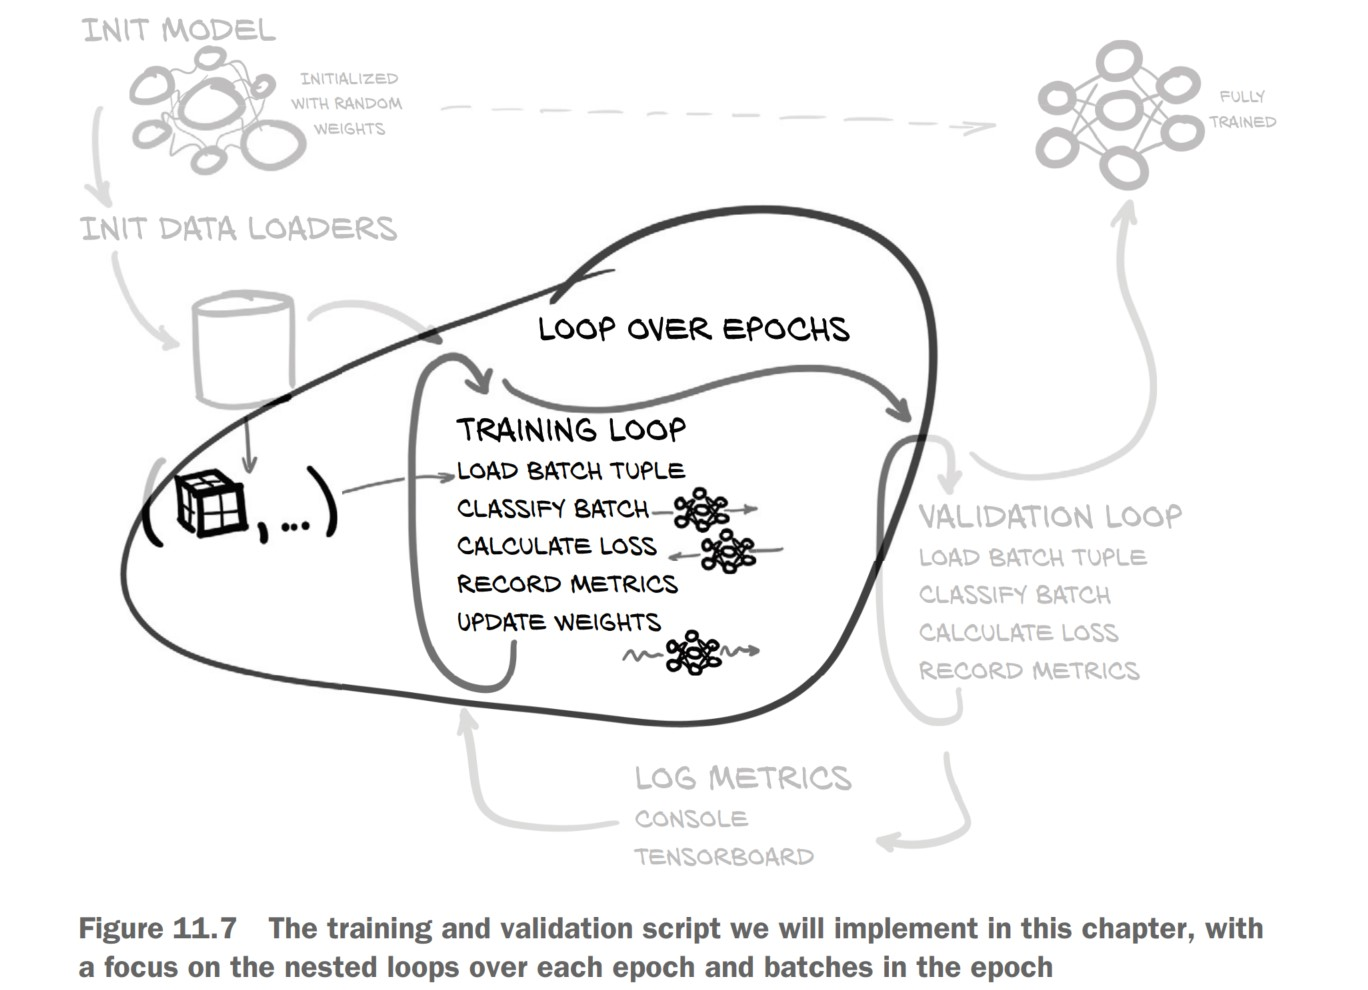

In [102]:
from IPython import display

display.Image("data/images/11.7.jpg")

In [35]:
def main(self):
    log.info("Starting {}, {}".format(type(self).__name__, self.cli_args))

    train_dl = self.initTrainDl()  #initializes a dataloader for the training dataset

    for epoch_ndx in range(1, self.cli_args.epochs + 1):
        log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
            epoch_ndx,
            self.cli_args.epochs,
            len(train_dl),
            self.cli_args.batch_size,
            (torch.cuda.device_count() if self.use_cuda else 1),
        )) 

        trnMetrics_t = self.doTraining(epoch_ndx, train_dl)
        self.logMetrics(epoch_ndx, 'trn', trnMetrics_t)


def doTraining(self, epoch_ndx, train_dl):
    self.model.train() # Set the model to training mode 
    trnMetrics_g = torch.zeros(  # Initializes an empty metrics array for the current epoch
        METRICS_SIZE,
        len(train_dl.dataset),
        device=self.device,
    )

    batch_iter = enumerateWithEstimate( # Sets up our batch looping and estimate the time remaining for the epoch.
        train_dl,
        "E{} Training".format(epoch_ndx),
        start_ndx=train_dl.num_workers,
    )
    for batch_ndx, batch_tup in batch_iter:
        self.optimizer.zero_grad()  # Frees any leftover gradient tensors

        loss_var = self.computeBatchLoss(  # We’ll discuss this method in detail in the next section.
            batch_ndx,
            batch_tup,
            train_dl.batch_size,
            trnMetrics_g
        )
        
        loss_var.backward() # Compute gradients
        self.optimizer.step() # Updates the model weights

    self.totalTrainingSamples_count += len(train_dl.dataset)

    return trnMetrics_g.to('cpu')


The **main differences** that we see from the training loops in earlier chapters are as
follows:
+ The *trnMetrics_g* tensor collects detailed per-class metrics during training.
+ We don’t directly iterate over the **train_dl** data loader. We use *enumerateWithEstimate* to provide an estimated time of completion. 
+ The actual loss computation is pushed into the *computeBatchLoss* method.

In the training loop code, we've wrapped **enumerate** with additional functionality that will be discussed later. The **trnMetrics_g** tensor is used to transport information about the model's behavior on a per-sample basis from the *computeBatchLoss* function to the **logMetrics** function. We will look at the **computeBatchLoss** function next, and then cover the **logMetrics** function after we finish the main training loop.

### <span style="color:#004654">11.5.1 The computeBatchLoss function</span>
***

The **computeBatchLoss** function calculates the loss over a batch of samples and records per-sample information about the output produced by the model, allowing us to analyze areas of difficulty. It uses **CrossEntropyLoss** to compute the loss, unpacks the batch tuple, moves the tensors to the GPU, and invokes the model.

In [36]:
def computeBatchLoss(self, batch_ndx, batch_tup, batch_size, metrics_g):
    input_t, label_t, _series_list, _center_list = batch_tup

    input_g = input_t.to(self.device, non_blocking=True)
    label_g = label_t.to(self.device, non_blocking=True)

    logits_g, probability_g = self.model(input_g)

    loss_func = nn.CrossEntropyLoss(reduction='none')
    loss_g = loss_func(
        logits_g,
        label_g[:, 1],
    ) 
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + label_t.size(0)

    # store the values of the label, predicted probability and loss for each example in the batch
    metrics_g[METRICS_LABEL_NDX, start_ndx:end_ndx] = \
        label_g[:, 1].detach()  # extract the labels (whether the nodule is malignant or benign) & detach it 
    #from the computation graph so that it does not accumulate gradients.
    metrics_g[METRICS_PRED_NDX, start_ndx:end_ndx] = \
        probability_g[:, 1].detach()
    metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = \
        loss_g.detach() # detach the computed loss from the computation graph

    return loss_g.mean()

The above function is not using the default behavior to get a loss value averaged over the batch. Instead, it returns a tensor of loss values, one per sample. This allows tracking individual losses, which can be aggregated as desired (per class, for example). <br>
The function returns the mean of those per-sample losses, which is equivalent to the batch loss. The function also records per-sample statistics for later analysis using the *metrics_g* parameter.

In [37]:
# These named array indexes are declared at module-level scope.
METRICS_LABEL_NDX = 0
METRICS_PRED_NDX = 1
METRICS_LOSS_NDX = 2
METRICS_SIZE = 3

def computeBatchLoss(self, batch_ndx, batch_tup, batch_size, metrics_g):
    input_t, label_t, _series_list, _center_list = batch_tup

    input_g = input_t.to(self.device, non_blocking=True)
    label_g = label_t.to(self.device, non_blocking=True)

    logits_g, probability_g = self.model(input_g)

    loss_func = nn.CrossEntropyLoss(reduction='none')
    loss_g = loss_func(
        logits_g,
        label_g[:, 1],
    )
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + label_t.size(0)

    metrics_g[METRICS_LABEL_NDX, start_ndx:end_ndx] = \
        label_g[:, 1].detach()
    metrics_g[METRICS_PRED_NDX, start_ndx:end_ndx] = \
        probability_g[:, 1].detach()
    metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = \
        loss_g.detach()

    return loss_g.mean()


The function **records label, prediction, and loss for each training/validation sample**, providing detailed information that can be used to investigate the model's behavior. This information can be used to compile per-class statistics or identify the most misclassified samples for further investigation. 

### <span style="color:#004654">11.5.2 The validation loop is similar</span>
***
The validation loop is similar to the training loop, but there is no weight updating or use of the loss value in validation.

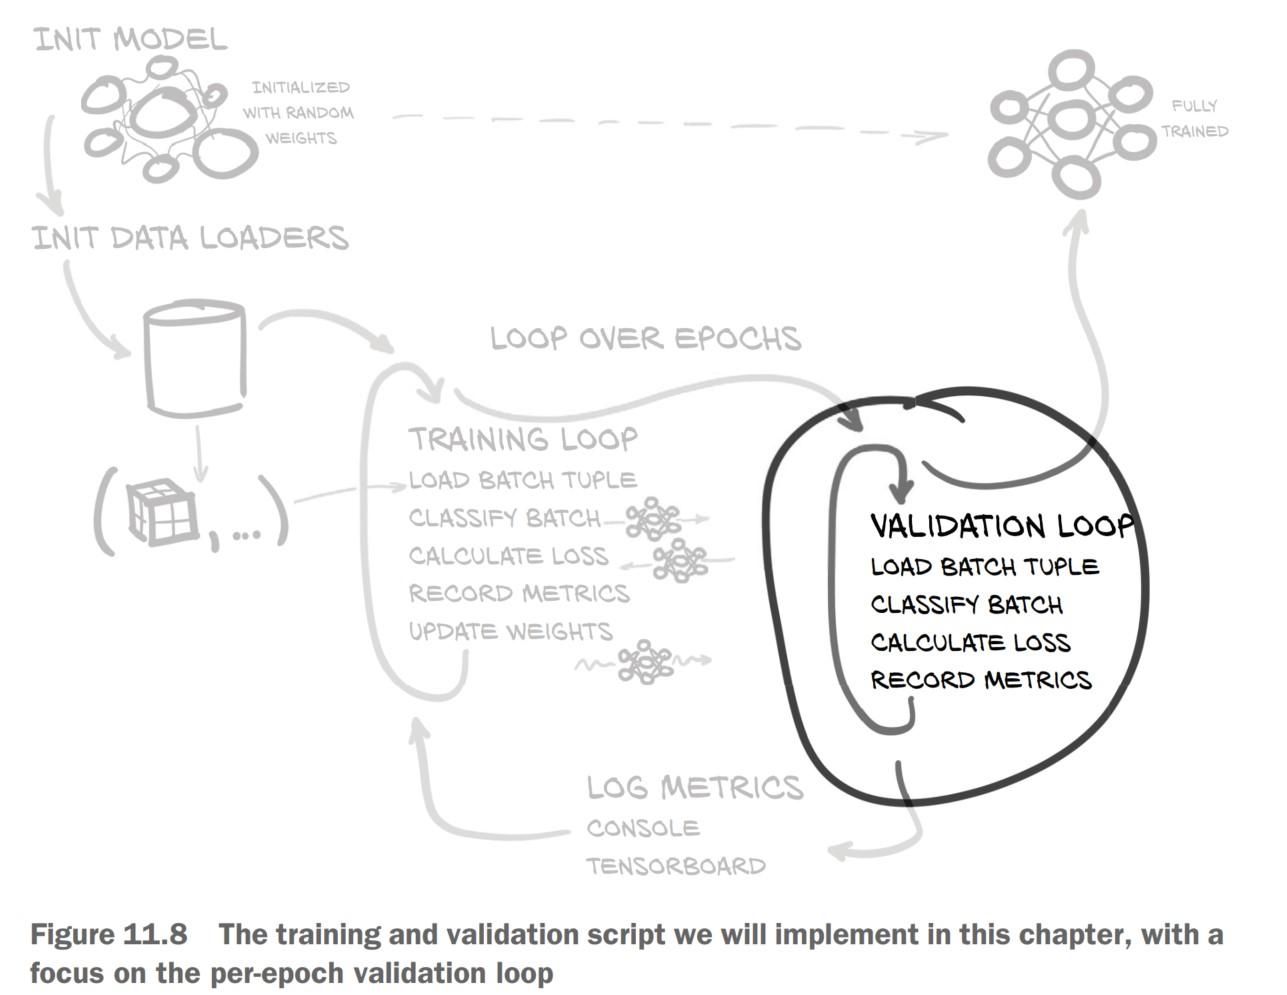

In [106]:
from IPython import display

display.Image("data/images/11.8.jpg")

The validation loop doesn't change anything about the model, and it's faster because of the *with torch.no_grad()* context manager which tells PyTorch that no gradients need to be computed. <br>

During the validation loop, we don't need to update the network weights or use the loss returned from *computeBatchLoss*, and we don't need to reference the optimizer. We only call *computeBatchLoss* to collect metrics in *valMetrics_g.*

In [38]:
def main(self):
    log.info("Starting {}, {}".format(type(self).__name__, self.cli_args))

    val_dl = self.initValDl()

    for epoch_ndx in range(1, self.cli_args.epochs + 1):
        log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
            epoch_ndx,
            self.cli_args.epochs,
            len(val_dl),
            self.cli_args.batch_size,
            (torch.cuda.device_count() if self.use_cuda else 1),
        ))

        valMetrics_t = self.doValidation(epoch_ndx, val_dl)
        self.logMetrics(epoch_ndx, 'val', valMetrics_t)


def doValidation(self, epoch_ndx, val_dl):
    with torch.no_grad():
        self.model.eval()
        valMetrics_g = torch.zeros(
            METRICS_SIZE,
            len(val_dl.dataset),
            device=self.device,
        )

        batch_iter = enumerateWithEstimate(
            val_dl,
            "E{} Validation ".format(epoch_ndx),
            start_ndx=val_dl.num_workers,
        )
        
        for batch_ndx, batch_tup in batch_iter:
            self.computeBatchLoss(
                batch_ndx, batch_tup, val_dl.batch_size, valMetrics_g)

    return valMetrics_g.to('cpu')

### <span style="color:#004654">11.6 Outputting performance metrics</span>
***
The last step of an epoch is to log the performance metrics. This helps to monitor the progress and detect any issues with the training. We collect the results in *trnMetrics_g* and *valMetrics_g* and use them to compute percent correct and average loss per class for the training and validation runs. Logging progress per epoch is a common practice, but the frequency can be manipulated to get feedback at a reasonable rate.

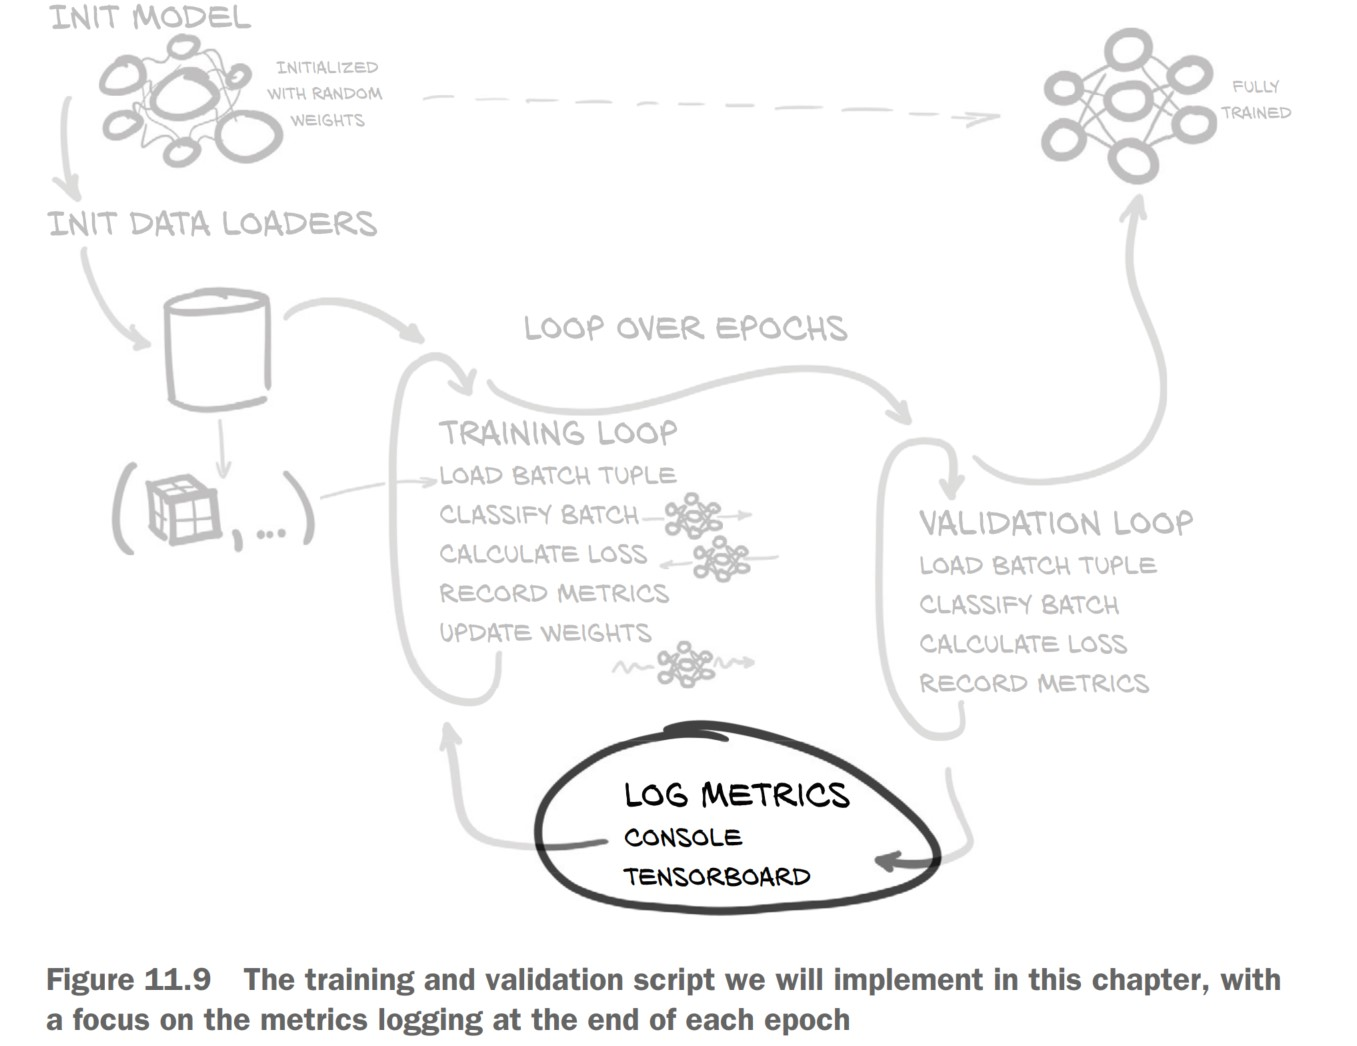

In [108]:
from IPython import display
display.Image("data/images/11.9.jpg")

### <span style="color:#004654">11.6.1 The logMetrics function</span>
***
Let’s talk about the high-level structure of the logMetrics function. The signature
looks like this.

In [ ]:
def logMetrics(
        self,
        epoch_ndx,
        mode_str, # training or validation mode
        metrics_t, # metrics values to be logged
        classificationThreshold=0.5,):
    

We log our results using **epoch_ndx** and **mode_str** to identify whether the metrics are for training or validation. We use either **trnMetrics_t** or **valMetrics_t** to collect the metrics from our training or validation loop. These metrics are returned as a tensor of floating-point values with three rows and as many columns as we have samples.
<br>
Those three rows correspond to the following constants.

In [40]:
# These are declared at module-level scope.
METRICS_LABEL_NDX = 0
METRICS_PRED_NDX = 1
METRICS_LOSS_NDX = 2
METRICS_SIZE = 3 

### <span style="color:#004654">CONSTRUCTING MASKS</span>

Now we will create masks to separate metrics for **nodule and non-nodule samples**, count the total number of samples for each class, and keep track of the number of correctly classified samples.

In [ ]:
negLabel_mask = metrics_t[METRICS_LABEL_NDX] <= classificationThreshold
negPred_mask = metrics_t[METRICS_PRED_NDX] <= classificationThreshold

posLabel_mask = ~negLabel_mask
posPred_mask = ~negPred_mask

Here we just compare the values in **metrics_t[METRICS_LABEL_NDX]** with the classificationThreshold to create a binary array, where **True** corresponds to a non-nodule (negative) label. <br>
We do the same to create the *negPred_mask*, but since the values in **metrics_t[METRICS_PRED_NDX]** can be any **floating-point number** between **0.0 and 1.0**, the **actual value** can be close to **0.5**. Finally, we create positive masks by inverting negative masks.
<br>

Next, we use those masks to compute some per-label statistics and store them in a dictionary, **metrics_dict**

In [ ]:
# Converts to a normal Python integer
neg_count = int(negLabel_mask.sum())  # number of negative examples
pos_count = int(posLabel_mask.sum())  # number of positive examples

neg_correct = int((negLabel_mask & negPred_mask).sum()) # negative examples that were correctly predicted
pos_correct = int((posLabel_mask & posPred_mask).sum()) # positve examples that were correctly predicted

metrics_dict = {} 
metrics_dict['loss/all'] = \
    metrics_t[METRICS_LOSS_NDX].mean()  # average loss for all examples
metrics_dict['loss/neg'] = \ 
    metrics_t[METRICS_LOSS_NDX, negLabel_mask].mean() # average loss for negative examples
metrics_dict['loss/pos'] = \
    metrics_t[METRICS_LOSS_NDX, posLabel_mask].mean() # the average loss for positive examples

metrics_dict['correct/all'] = (pos_correct + neg_correct) / np.float32(metrics_t.shape[1]) * 100 # the percentage of correct predictions for all examples
metrics_dict['correct/neg'] = neg_correct / np.float32(neg_count) * 100 #  the percentage of correct predictions for negative examples 
metrics_dict['correct/pos'] = pos_correct / np.float32(pos_count) * 100 # the percentage of correct predictions for positive examples 

During training, we calculate the **average loss over the entire epoch**, which is the metric that we want to minimize. <br> **We use a mask to limit the loss averaging to only those samples with a negative or positive label**. This can help us identify if one class is consistently harder to classify than another. <br><br>
We also determine the fraction of samples we classified correctly and the fraction correct from each label. These numbers are displayed as percentages and can guide our efforts to improve. Finally, **we log our results with three calls to log.info.**

In [ ]:
log.info(
    ("E{} {:8} {loss/all:.4f} loss, "
     + "{correct/all:-5.1f}% correct, "
     ).format(
        epoch_ndx,
        mode_str,
        **metrics_dict,
    )
)


log.info(
    ("E{} {:8} {loss/neg:.4f} loss, "
     + "{correct/neg:-5.1f}% correct ({neg_correct:} of {neg_count:})"
     ).format(
        epoch_ndx,
        mode_str + '_neg',
        neg_correct=neg_correct,
        neg_count=neg_count,
        **metrics_dict,
    )
)

log.info(
    ("E{} {:8} {loss/pos:.4f} loss, "
     + "{correct/pos:-5.1f}% correct ({pos_correct:} of {pos_count:})"
     ).format(
        epoch_ndx,
        mode_str + '_pos',
        pos_correct=pos_correct,
        pos_count=pos_count,
        **metrics_dict,
    )
)


### <span style="color:#004654">11.7 Running the training script</span>
***


Now that we have completed all the pre-reqs for the training, we can actually start the training process. We have already defined a run function earlier that we can use to call the training script and start training our model.

In [48]:
run('prepcache.LunaPrepCacheApp')

run('training.LunaTrainingApp', '--epochs=20')

2023-05-07 03:02:35,695 INFO     pid:25092 __main__:006:run Running: prepcache.LunaPrepCacheApp(['--num-workers=4']).main()
2023-05-07 03:02:35,696 INFO     pid:25092 prepcache:044:main Starting LunaPrepCacheApp, Namespace(batch_size=1024, num_workers=4)
2023-05-07 03:03:36,021 INFO     pid:25092 dsets:182:__init__ <dsets.LunaDataset object at 0x000001FC449EA700>: 13564 training samples
2023-05-07 03:03:36,023 WARNING  pid:25092 util.util:219:enumerateWithEstimate Stuffing cache ----/14, starting
2023-05-07 03:03:45,546 INFO     pid:25092 util.util:236:enumerateWithEstimate Stuffing cache    8/14, done at 2023-05-07 03:03:47, 0:00:03
2023-05-07 03:03:46,626 WARNING  pid:25092 util.util:249:enumerateWithEstimate Stuffing cache ----/14, done at 2023-05-07 03:03:46
2023-05-07 03:03:46,628 INFO     pid:25092 __main__:013:run Finished: prepcache.LunaPrepCacheApp.['--num-workers=4']).main()
2023-05-07 03:03:46,629 INFO     pid:25092 __main__:006:run Running: training.LunaTrainingApp(['--num-

### <span style="color:#004654">11.7.1 Needed data for training</span>
***
In order to train the data, we first have to download it from the Luna Dataset Link: https://zenodo.org/record/3723295/files/subset0.zip. 

Due to Resource constraints we had to remove some files from the subset0 as well to run the process. The original dataset contains a total of 10 subsets ranging from 0-9. 

In [60]:
%cd C:\Users\Shakeel Ahmad\link_pytorch-main\p2ch11\data-unversioned\part2\luna\subset0
%ls

C:\Users\Shakeel Ahmad\link_pytorch-main\p2ch11\data-unversioned\part2\luna\subset0
 Volume in drive C has no label.
 Volume Serial Number is A4ED-FB26

 Directory of C:\Users\Shakeel Ahmad\link_pytorch-main\p2ch11\data-unversioned\part2\luna\subset0

05/05/2023  03:18 PM    <DIR>          .
05/05/2023  03:17 PM    <DIR>          ..
04/30/2023  12:02 PM               428 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
04/30/2023  12:02 PM        63,438,848 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.raw
04/30/2023  12:02 PM               411 1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
04/30/2023  12:02 PM        62,390,272 1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.raw
04/30/2023  12:02 PM               423 1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
04/30/2023  12:02 PM        84,410,368 1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.raw
04/30/2023  12:02

### <span style="color:#004654">11.7.2 Interlude: The enumerateWithEstimate function</span>
***

This function actually helps us to "yield" i-e log the timestamps for the given action being performed. This helps us in estimating the time for the remaning operations to be executed in the future iterations. 

In [64]:
def enumerateWithEstimate(
iter,
desc_str,
start_ndx=0,
print_ndx=4,
backoff=None,
iter_len=None,
):
    for (current_ndx, item) in enumerate(iter):
        yield (current_ndx, item)

### <span style="color:#004654">11.8 Evaluating the model</span>
***

#### Back to the Training loop

Now as we can see that a lot of times we are getting the correction as 98-100%, but does that does that define that our model is fully trained to tacle the problem? 

If we look closely, we'll see that majority of the 99% of the data is defined as "nodules | No Tumour" which means that the model is outputing incorrect results. It is classifying everything to the negative class. 

As we move a little forward, we see that the results are slightly getting better, but the rate at which the model is learning is insufficient to solve our problem with these limited number of epochs. 

We can also conclude that our logging can be slightly misleading for any newcommer, so we need to use a better tool for logging. 

### <span style="color:#004654">11.9 Graphing training metrics with TensorBoard </span>
***

For our logging we'll now switch to TensorBoard, that will allow us to look closely at the trends to help us evaluate the performance in a better way. 

### <span style="color:#004654">11.9.1 Running TensorBoard </span>
***


In [11]:
%cd C:\Users\Shakeel Ahmad\link_pytorch-main\p2ch11\runs\p2ch11
!dir

C:\Users\Shakeel Ahmad\link_pytorch-main\p2ch11\runs\p2ch11
 Volume in drive C has no label.
 Volume Serial Number is A4ED-FB26

 Directory of C:\Users\Shakeel Ahmad\link_pytorch-main\p2ch11\runs\p2ch11

05/07/2023  03:04 AM    <DIR>          .
05/07/2023  02:58 AM    <DIR>          ..
05/07/2023  03:04 AM    <DIR>          2023-05-07_03.03.46-trn_cls-dwlpt
05/07/2023  03:04 AM    <DIR>          2023-05-07_03.03.46-val_cls-dwlpt
               0 File(s)              0 bytes
               4 Dir(s)  63,702,020,096 bytes free


Now, in order to run tensorboard, we'll have to install it using 'pip install tensorboard'.

We'll then run tensorboard using our terminal and call it in the following way:

'tensorboard --logdir runs/'

'--logdir' refers to the directory where our training iterations are stored, and can be seen in the list of files above. 

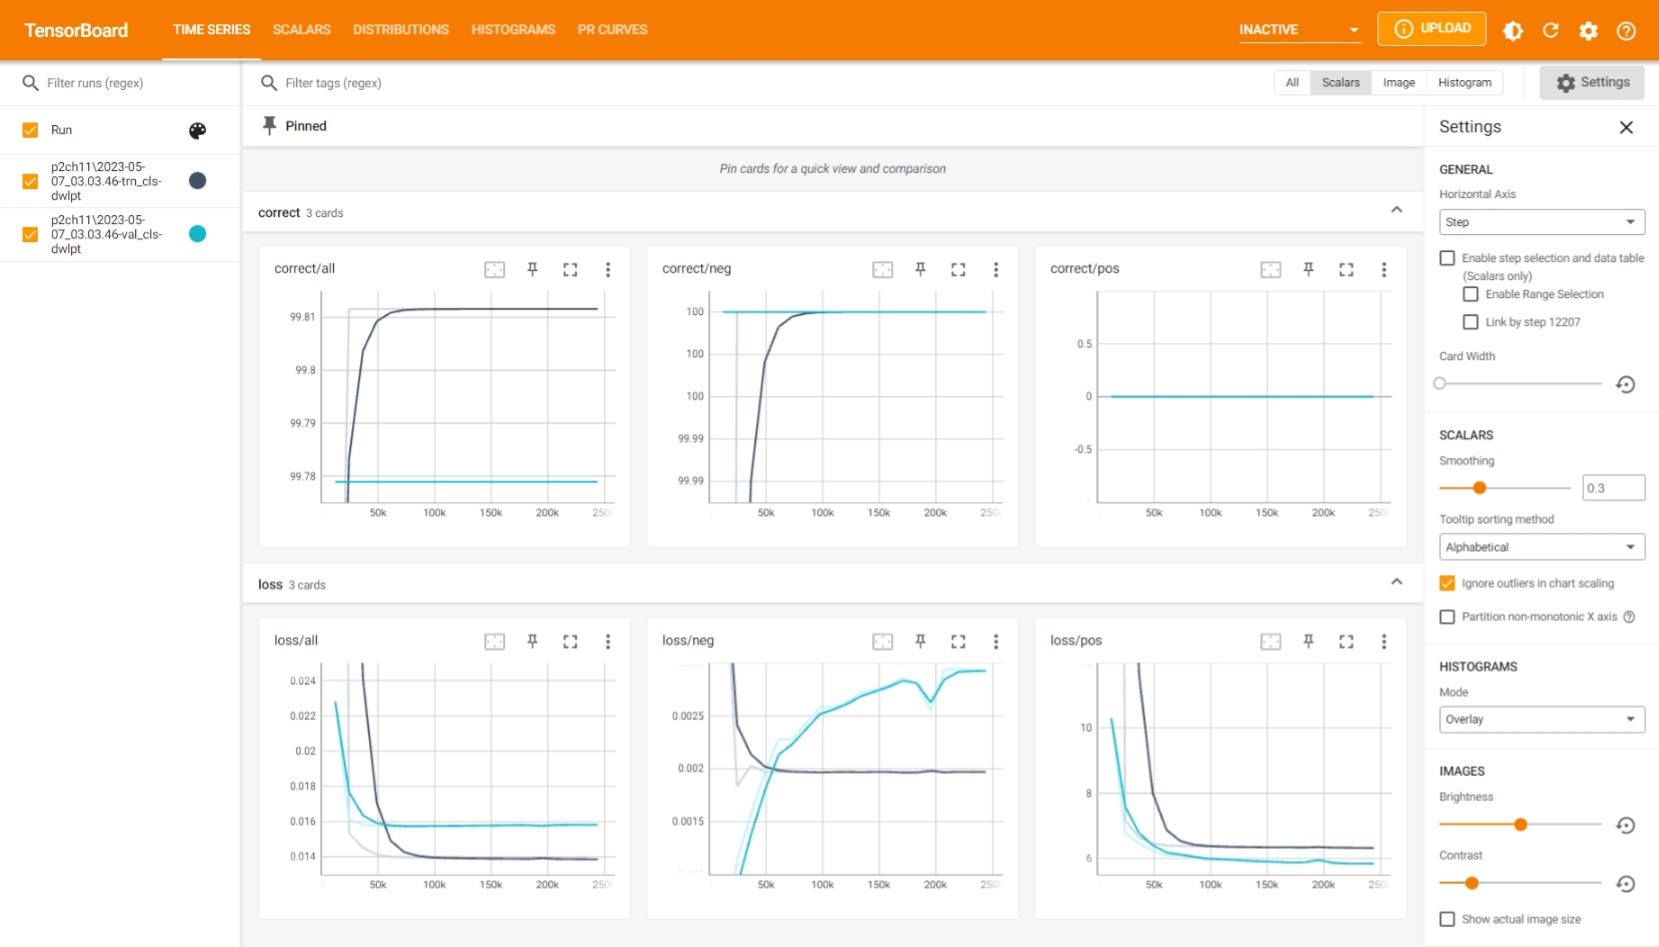

In [14]:
from IPython import display
display.Image(r"C:\Users\Shakeel Ahmad\link_pytorch-main\p2ch11\data\images\11.9.1_our_results.jpg")

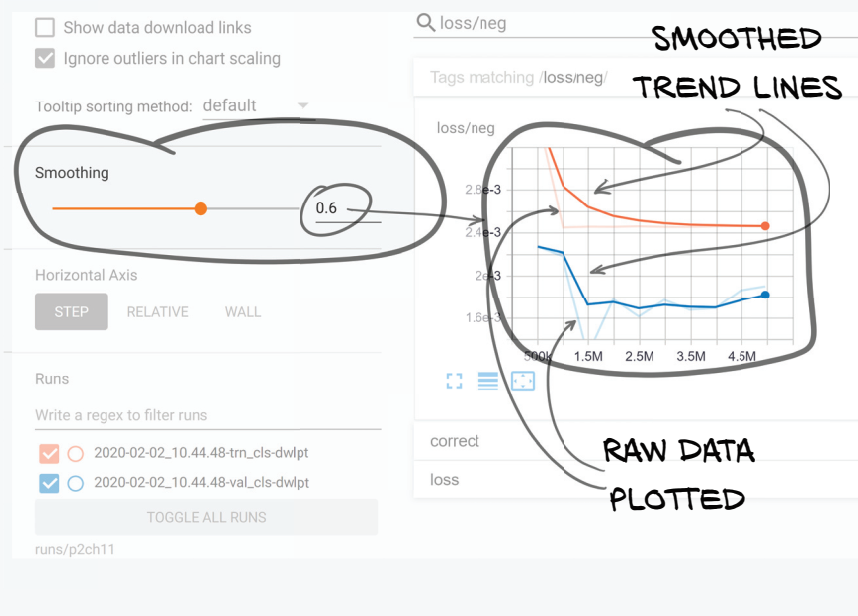

We can increase the smoothing to visualize the trend lines in an effective manner. 

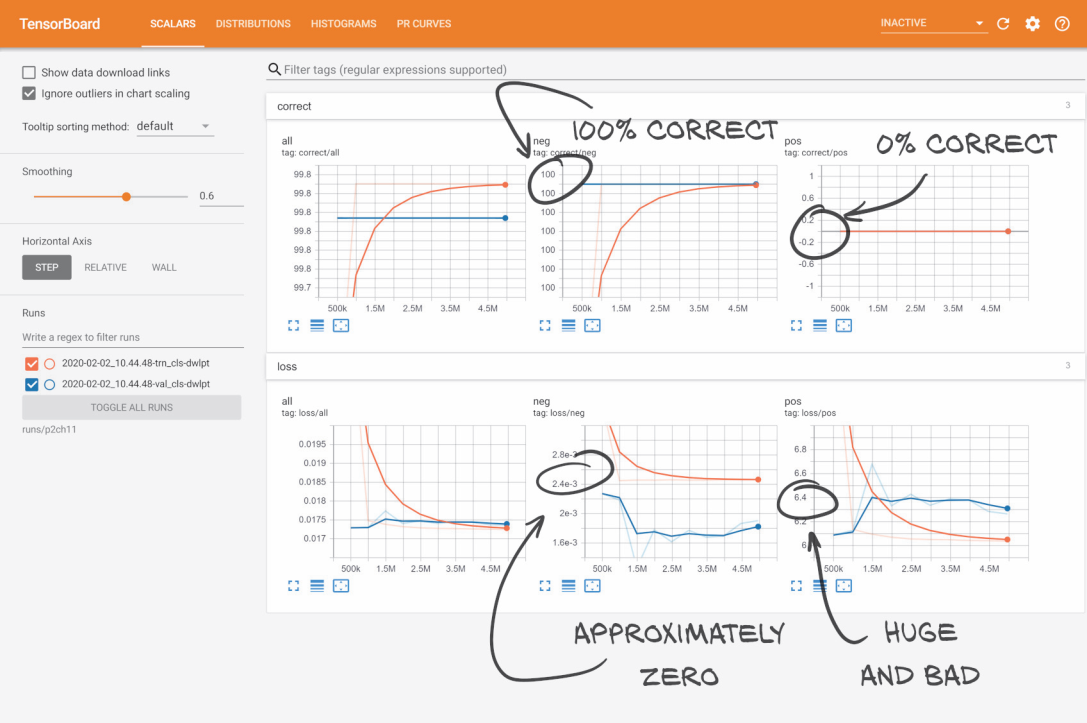

Our model is identifying almost all the inputs as no tumor, something we dicussed earlier, now we can visualize it as well. 

The loss values are really high and none of the positive results are detected correctly. 

### <span style="color:#004654">11.9.2 Adding TensorBoard support to the metrics logging function</span>
***
Torch allows us to use its function SummaryWriter from "torch.utils.tensorboard" in order for us to log the results to be visualized using TensorBoard. 

We call this function using the logMetrics() defined earlier. This if statement allows clogging up the runs directory with unsuccessful results. 

In [ ]:
def initTensorboardWriters(self):
if self.trn_writer is None:
    log_dir = os.path.join('runs', self.cli_args.tb_prefix, self.time_str)
    self.trn_writer = SummaryWriter(
    log_dir=log_dir + '-trn_cls-' + self.cli_args.comment)
    self.val_writer = SummaryWriter(
    log_dir=log_dir + '-val_cls-' + self.cli_args.comment)

### Writing Scalars to TensorBoard

We use the builtin add_scalar function provided by the PyTorch. 

It is defined with the following parameters: 

In [ ]:
def add_scalar(self, tag, scalar_value, global_step=None, walltime=None):

The tag parameter tells TensorBoard which graph we’re adding values to, and the scalar_value parameter is our data point’s Y-axis value. The global_step parameter acts as the X-axis value.


This is how we call it in our code:

In [ ]:
for key, value in metrics_dict.items():
    writer.add_scalar(key, value, self.totalTrainingSamples_count)

1. The slashes in our key names (such as 'loss/all') result in TensorBoard grouping the charts by the substring before the '/'.
2. The documentation suggests that we should be passing in the epoch number as the global_step parameter, but that results in some complications. By using the number of training samples presented to the network, we can do things like change the number of samples per epoch and still be able to compare those future graphs to the ones we’re
creating now.

### <span style="color:#004654">11.10 Why isn’t the model learning to detect nodules?</span>
***
We discussed earlier that the performance of our model was not at all good, but if we observe the trend, we see that we are learning at least something with each passing epoch. 

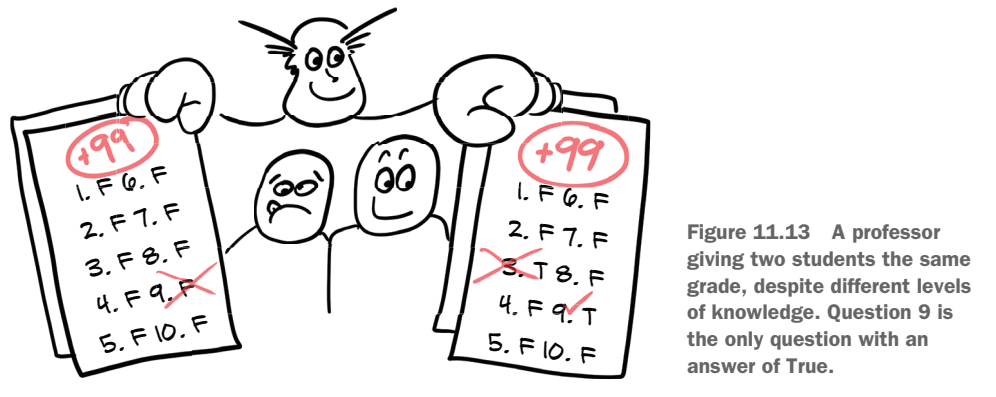

Our results are somehow similar to this image, our model is classifying everything as false, which might be giving good results, but that does not provide a solution to our problem statement. 

That concludes that we are on the right track, we just have to change our training approach, that we'll be covering in the next chapter.

### <span style="color:#004654">11.11 Conclusion</span>
***

We have covered a lot of things in this chapter. 
1. We have a model that we trained from the scratch. 
2. We were able to log our results in a text as well as a graphical manner. 
3. Our results are not usable yet, but metrics suggest that the problem can be tackled trough deep learning, by changing the method.